In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# To ensure consistent results
tf.random.set_seed(42)

In [2]:
# --- Define Relative Paths ---
# This makes the notebook portable and easier to run on different machines.
TRAIN_DIR = "casting/train"
TEST_DIR = "casting/test"

In [3]:
# --- Create Data Generators ---

# For the training data, we add augmentation and a validation split.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of training data for validation
)

# For the test data, we ONLY rescale. No augmentation here.
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# --- Flow Data from Directories ---

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# Training Generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',  # Using full RGB
    subset='training'  # Specify this is the training subset
)

# Validation Generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='validation' # Specify this is the validation subset
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False # Keep shuffle off for final evaluation
)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [5]:
def build_model(hp):
    """
    Builds a CNN model with tunable hyperparameters.
    The 'hp' object allows us to define search spaces for parameters.
    """
    model = keras.Sequential()
    
    # Define input shape for RGB images
    model.add(layers.Input(shape=(64, 64, 3)))

    # --- Tunable Convolutional Block 1 ---
    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    hp_kernel_1 = hp.Choice('kernel_1', values=[3, 5])
    model.add(layers.Conv2D(filters=hp_filters_1, kernel_size=hp_kernel_1, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    # --- Tunable Convolutional Block 2 ---
    hp_filters_2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
    model.add(layers.Conv2D(filters=hp_filters_2, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # --- Tunable Convolutional Block 3 ---
    hp_filters_3 = hp.Int('filters_3', min_value=32, max_value=128, step=32)
    model.add(layers.Conv2D(filters=hp_filters_3, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    # --- Flatten and Dense Layers ---
    model.add(layers.Flatten())

    hp_dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)
    model.add(layers.Dense(units=hp_dense_units, activation='relu'))
    
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(rate=hp_dropout))

    # --- Output Layer ---
    model.add(layers.Dense(1, activation='sigmoid'))

    # --- Tune the Learning Rate ---
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
# We use Hyperband, an efficient algorithm for hyperparameter tuning.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20, # Max epochs to train one model configuration
    factor=3,
    directory='keras_tuner_dir', # Directory to store results
    project_name='casting_defect_rgb_tuning'
)

# Add an EarlyStopping callback to prevent overfitting and save time during the search
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [7]:
print("\nStarting hyperparameter search...")
# The search function will test different hyperparameter combinations.
# This will take some time to run.
tuner.search(
    train_generator,
    epochs=50, # This is a large number, but EarlyStopping will handle it
    validation_data=validation_generator,
    callbacks=[stop_early]
)

print("\nHyperparameter search complete.")

Trial 30 Complete [00h 09m 26s]
val_accuracy: 0.9374057054519653

Best val_accuracy So Far: 0.9834087491035461
Total elapsed time: 01h 20m 12s

Hyperparameter search complete.


In [8]:
# Retrieve the best set of hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal parameters are:
- Filters in Conv Layer 1: {best_hps.get('filters_1')} with kernel size {best_hps.get('kernel_1')}
- Filters in Conv Layer 2: {best_hps.get('filters_2')}
- Filters in Conv Layer 3: {best_hps.get('filters_3')}
- Units in Dense Layer: {best_hps.get('dense_units')}
- Dropout Rate: {best_hps.get('dropout'):.2f}
- Learning Rate: {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. The optimal parameters are:
- Filters in Conv Layer 1: 64 with kernel size 5
- Filters in Conv Layer 2: 64
- Filters in Conv Layer 3: 96
- Units in Dense Layer: 384
- Dropout Rate: 0.30
- Learning Rate: 0.001



In [10]:
# Build the model with the best hyperparameters
# The fix is to call .hypermodel on the tuner object
final_model = tuner.hypermodel.build(best_hps)

# Print a summary of the final, optimized model architecture
print("\n--- Final Model Architecture ---")
final_model.summary()

# Train the final model on the full training data
print("\nTraining the final model with the best hyperparameters...")
history = final_model.fit(
    train_generator,
    epochs=50, # Train for a good number of epochs
    validation_data=validation_generator
)


--- Final Model Architecture ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │     2,359,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,457,249 (9.37 MB)

 Trainable params: 2,457,249 (9.37 MB)

 Non-trainable params: 0 (0.00 B)


Training the final model with the best hyperparameters...
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 63s 366ms/step - accuracy: 0.5966 - loss: 0.6691 - val_accuracy: 0.6516 - val_loss: 0.6248
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.6768 - loss: 0.6005 - val_accuracy: 0.7270 - val_loss: 0.5414
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.7347 - loss: 0.5126 - val_accuracy: 0.7232 - val_loss: 0.5228
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.8001 - loss: 0.4216 - val_accuracy: 0.8394 - val_loss: 0.3421
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8410 - loss: 0.3543 - val_accuracy: 0.8469 - val_loss: 0.3496
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8781 - loss: 0.2821 - val_accuracy: 0.8326 - val_loss: 0.3659
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.8950 - loss: 0.2483 - val_accuracy: 0.9193 - val_loss: 0.1924
Epoch 8/50
166/166 ━━━━━

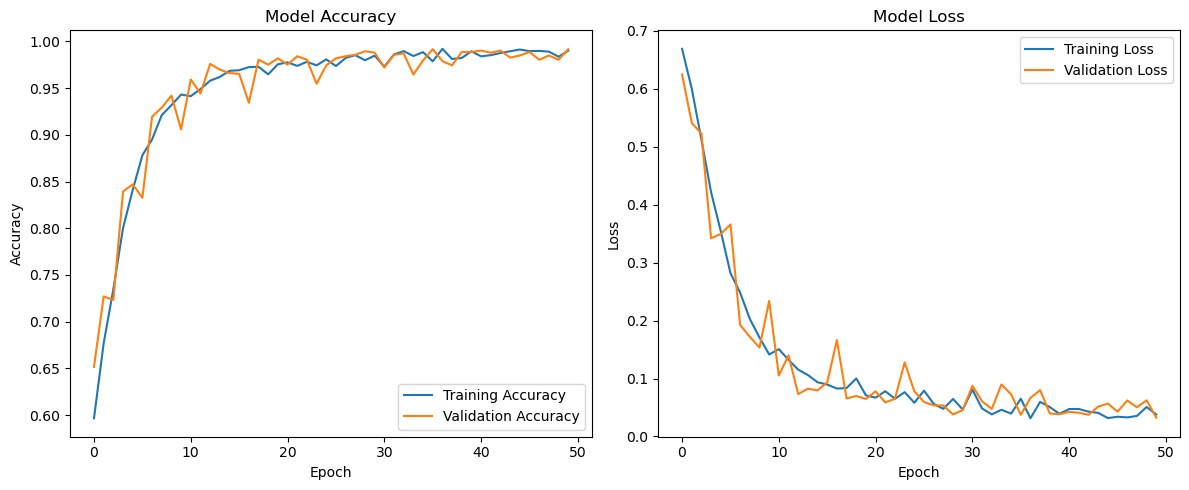

In [11]:
# --- Plot Training and Validation History ---

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.9077 - loss: 0.2889

✅ Final Test Accuracy: 90.77%
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

📊 Classification Report:

              precision    recall  f1-score   support

   Defective       1.00      0.85      0.92       453
          OK       0.80      1.00      0.89       262

    accuracy                           0.91       715
   macro avg       0.90      0.93      0.90       715
weighted avg       0.93      0.91      0.91       715


 Confusion Matrix:



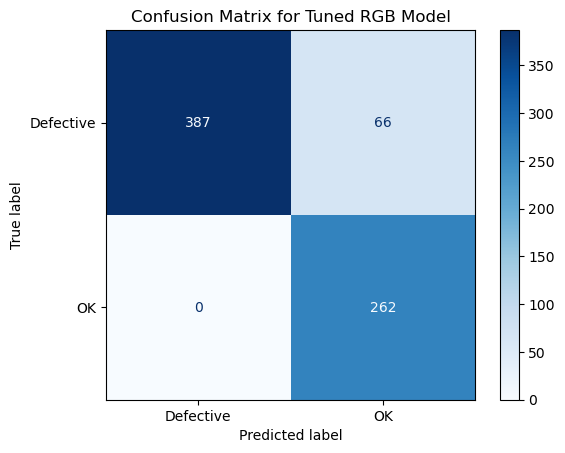

In [12]:
# Evaluate the tuned model on the test set
test_loss, test_acc = final_model.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_acc*100:.2f}%")

# --- Generate Classification Report and Confusion Matrix ---
# Get predictions on the test set
y_pred_probs = final_model.predict(test_generator)
y_pred_classes = (y_pred_probs > 0.5).astype("int32").ravel()

# Get true labels
y_true = test_generator.classes

# Print the classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=["Defective", "OK"]))

# Display the confusion matrix
print("\n Confusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Defective", "OK"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Tuned RGB Model")
plt.show()